In [1]:
import spotiphy
import numpy as np
import pandas as pd
import matplotlib as mpl
import scanpy as sc
import squidpy as sq
import importlib as imp
imp.reload(spotiphy)
imp.reload(spotiphy.segmentation)
imp.reload(spotiphy.sc_reference)

<module 'spotiphy.sc_reference' from 'C:\\Users\\zzheng92\\Desktop\\Spotiphy\\spotiphy\\sc_reference.py'>

In [41]:
%%time
adata_sc_files = ["F:/Ziqian Zheng/Spatial omics/Public dataset/scRNA/scRNA.h5ad",
                  "F:/Ziqian Zheng/Spotiphy_data/SCRNA/sum_43plus_anno.h5ad",
                  "F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/NewMerge_harmony_noDAM.h5ad",           #
                  "F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/NewMerge_harmony_merge1.h5ad",    # Merged subtypes
                  "F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/NewMerge_harmony_merge2.h5ad"]    # TCell and BCell are not merged
adata_sc = sc.read_h5ad(adata_sc_files[2])
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample216/outs")
# adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample216/outs")
adata_st.var_names_make_unique()
results_folder = 'results/216_merge/'
key_type = 'cell_type'
type_list = sorted(list(adata_sc.obs[key_type].unique()))
adata_sc_orig = adata_sc.copy()
adata_st_orig = adata_st.copy()

anndata.py (1832): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: total: 28.5 s
Wall time: 43.5 s


In [26]:
# adata_sc_orig.obs[key_type][adata_sc.obs[key_type]=='DAM'] = 'Microglia'
# adata_sc.obs[key_type][adata_sc.obs[key_type]=='DAM'] = 'Microglia'
# type_list = sorted(list(adata_sc.obs[key_type].unique()))

In [42]:
print(type_list)
print(len(type_list))

['Astro', 'BCell', 'CAs', 'DG', 'Endo', 'L2/3 IT CTX', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX', 'L5/6 NP CTX', 'L6 CT CTX', 'L6b CTX', 'Lamp5', 'Macrophage', 'Microglia', 'Neutrophil', 'Oligo', 'Pericyte', 'Pvalb', 'Sncg', 'Sst', 'TCell', 'Vip']
23


### Deconvolution

In [5]:
%%time
adata_sc, adata_st = spotiphy.initialization(adata_sc, adata_st)

CPU times: total: 2min 34s
Wall time: 2min 35s


In [6]:
%%time
marker_gene = spotiphy.marker_selection(adata_sc, key_type=key_type, return_dict=False, n_select=40, threshold_z=-1)
adata_sc = adata_sc[:, marker_gene]
adata_st = adata_st[:, marker_gene]

CPU times: total: 1min 28s
Wall time: 1min 29s


In [7]:
# marker_gene_dict = spotiphy.marker_selection(adata_sc, key_type=key_type, return_dict=True, n_select=40)
# marker_gene = []
# marker_gene_label = []
# for type_ in type_list:
#     marker_gene.extend(marker_gene_dict[type_])
#     marker_gene_label.extend([type_]*len(marker_gene_dict[type_]))
# marker_gene_df = pd.DataFrame({'gene':marker_gene, 'label':marker_gene_label})
# marker_gene_df.to_csv('marker_gene.csv')

In [8]:
%%time
sc_ref = spotiphy.construct_sc_ref(adata_sc, key_type=key_type)
# spotiphy.plot_sc_ref(sc_ref, type_list)

38it [00:00, 60.56it/s]

CPU times: total: 5.61 s
Wall time: 5.68 s


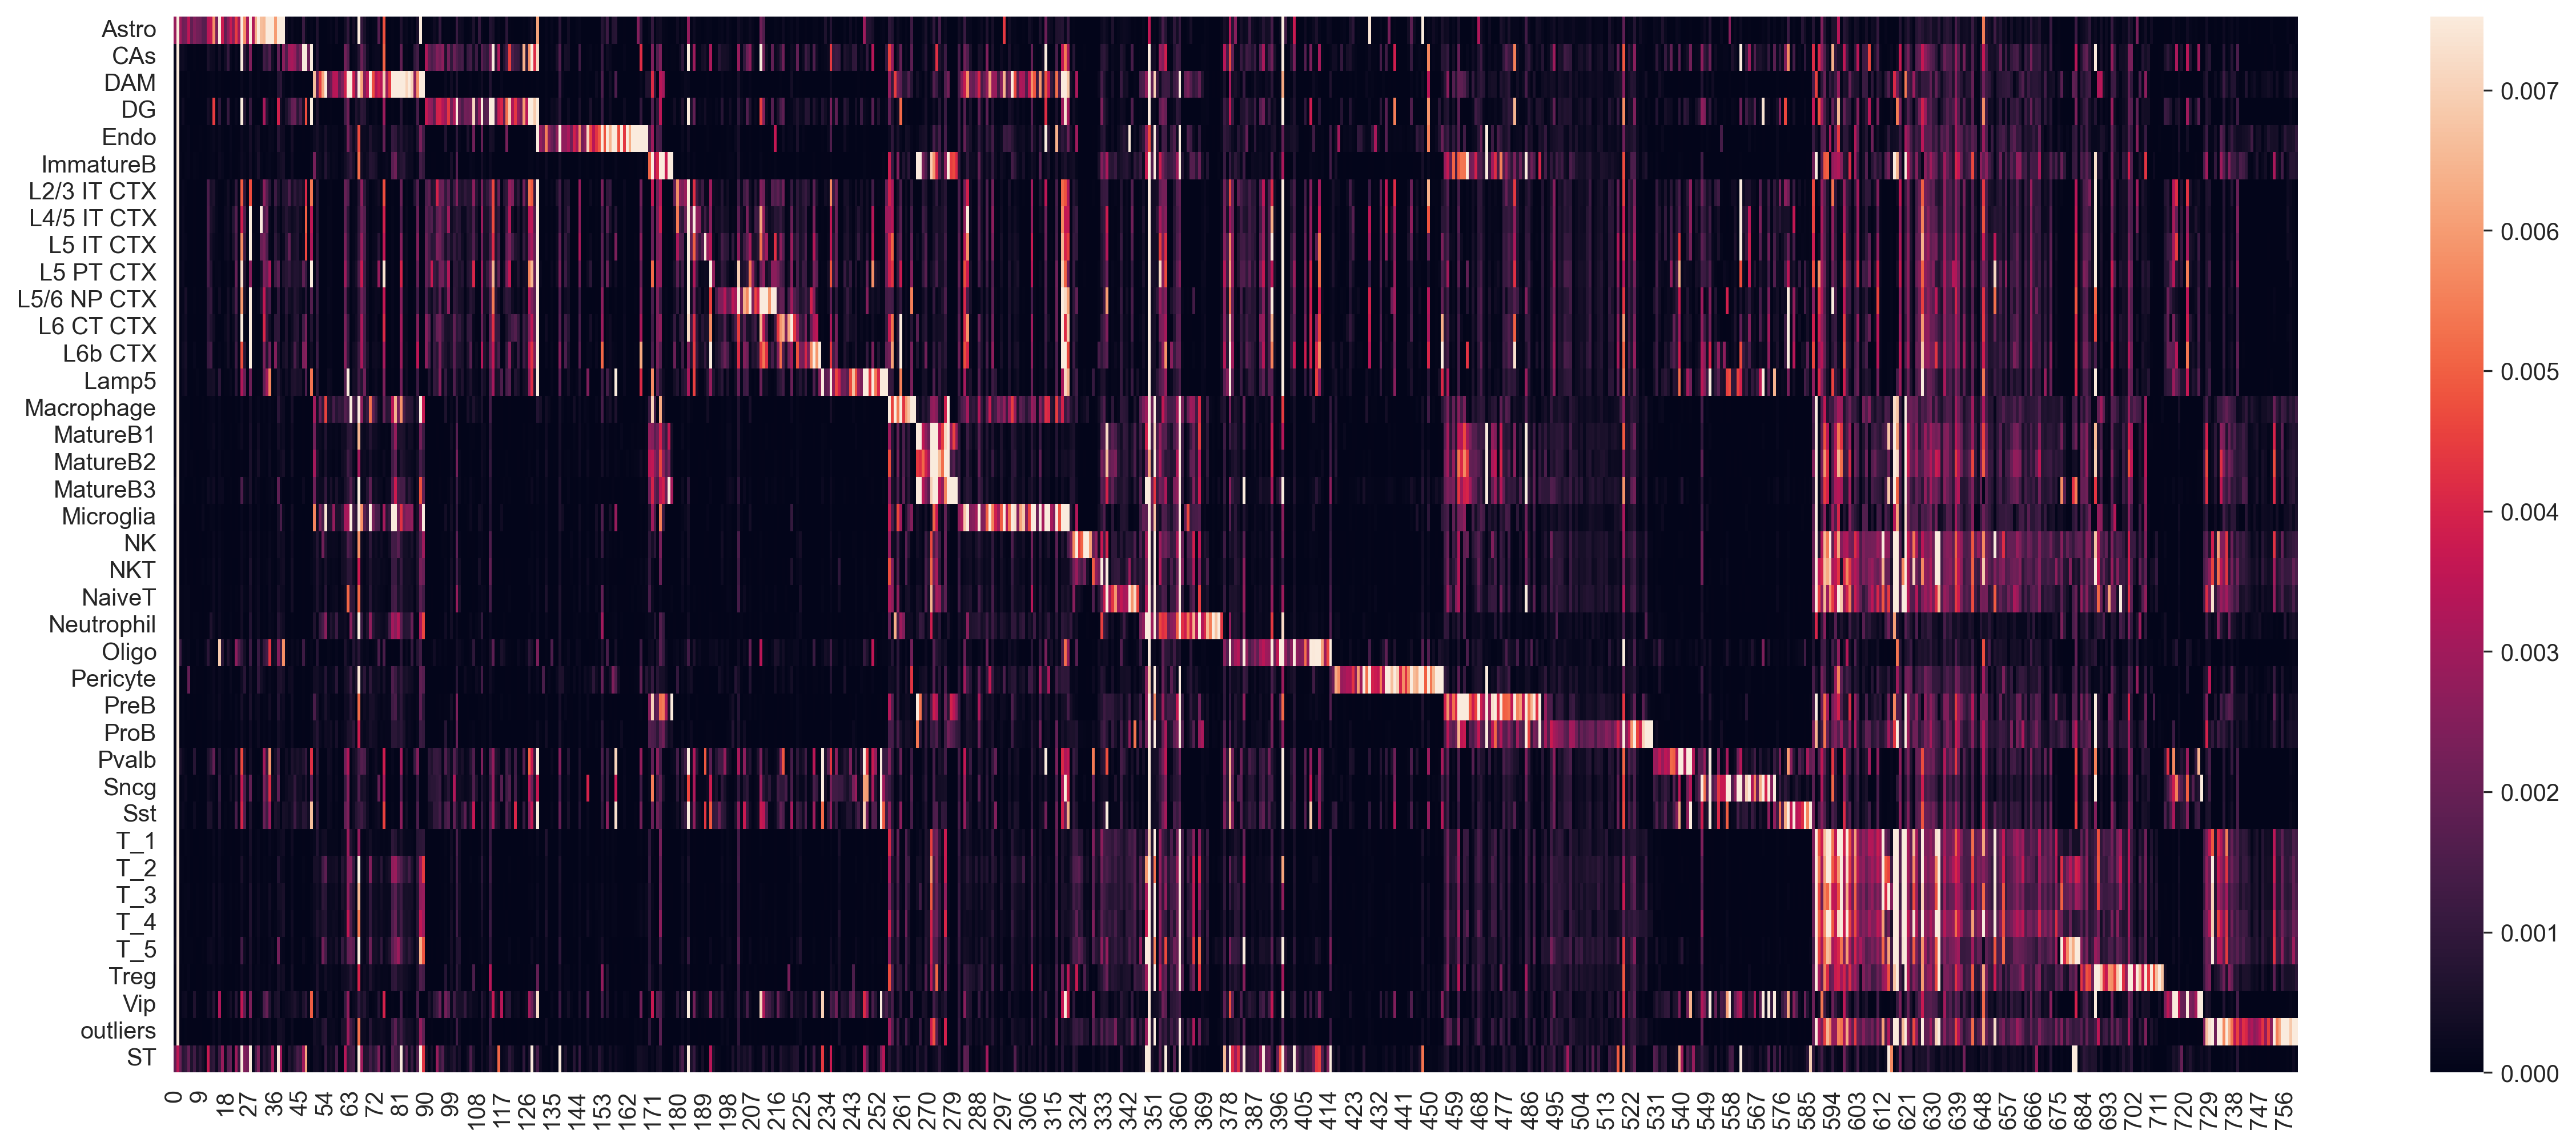

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
ST = adata_st.X
ST = np.sum(ST, axis=0)
ST = ST/np.sum(ST)
plt.figure(figsize=(20,8), dpi=300)
sc_ref_df = pd.DataFrame(np.vstack([sc_ref, ST]), index=type_list+['ST'])
ax = sns.heatmap(sc_ref_df, robust=True)

In [ ]:
%%time
X = np.array(adata_st.X)
pyro_params = spotiphy.deconvolution.deconvolute(X, sc_ref, n_epoch=7000, plot=True)
sigma = pyro_params['sigma'].cpu().detach().numpy()
mean_exp = np.array([np.mean(np.sum(adata_sc.X[adata_sc.obs[key_type]==type_list[i]], axis=1)) for i in range(len(type_list))])
cell_proportion = sigma/mean_exp
cell_proportion = cell_proportion/np.sum(cell_proportion, axis=1)[:, np.newaxis]
adata_st.obs[type_list] = cell_proportion
# np.save(results_folder+'proportion.npy', cell_proportion)

In [27]:
# np.save(results_folder+'proportion_TB.npy', cell_proportion)
cell_proportion = np.load(results_folder+'proportion_noDAM.npy')
adata_st.obs[type_list] = cell_proportion
type_list_order = ['L2/3 IT CTX', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX', 'L5/6 NP CTX', 'L6 CT CTX', 'L6b CTX', 'CAs', 'DG', 'Lamp5', 'Pvalb', 'Sncg',
                   'Sst', 'Vip', 'Endo', 'Astro', 'Oligo', 'Pericyte', 'Macrophage', 'Microglia', 'DAM', 'Neutrophil', 'TCell', 'BCell']
# type_list_order = ['L2/3 IT CTX', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX', 'L5/6 NP CTX', 'L6 CT CTX', 'L6b CTX', 'CAs', 'DG', 'Lamp5', 'Pvalb', 'Sncg',
#                    'Sst', 'Vip', 'Endo', 'Astro', 'Oligo', 'Pericyte', 'Macrophage', 'Microglia', 'DAM', 'Neutrophil',
#                    'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'Treg', 'NKT', 'NaiveT', 'NK', 'outliers',
#                    'MatureB1', 'MatureB2', 'MatureB3', 'ImmatureB', 'PreB', 'ProB']
type_list_order.remove('DAM')

In [13]:
adata_st.var.rename(index={'Lamp5': 'Lamp5_g', 'Pvalb': 'Pvalb_g', 'Sst': 'Sst_g', 'Vip': 'Vip_g',
                           'Sncg': 'Sncg_g'}, inplace=True)

In [14]:
vamx = np.quantile(adata_st.obs[type_list_order].values, 0.98, axis=0)
vamx[vamx<0.001] = 0.001

In [ ]:
with mpl.rc_context({'figure.figsize': [4, 4.5], 'figure.dpi': 600}):
    ax = sc.pl.spatial(adata_st, cmap='magma', color=type_list_order, img_key='hires', vmin=0, vmax=list(vamx), ncols=5, size=1.3, show=False)
    ax[0].get_figure().savefig(results_folder+'spotiphy_TB.jpg', bbox_inches='tight')

### Decomposition

In [34]:
imp.reload(spotiphy.deconvolution)

<module 'spotiphy.deconvolution' from 'C:\\Users\\zzheng92\\Desktop\\Spotiphy\\spotiphy\\deconvolution.py'>

In [43]:
cell_proportion = np.load(results_folder+'proportion_noDAM.npy')
n_cell_df = pd.read_csv(results_folder+'Segmentation/n_cell_df.csv', header=0)
n_cell = n_cell_df['cell_count'].values

In [44]:
%%time
adata_st_decomposed = spotiphy.deconvolution.decomposition(adata_st_orig, adata_sc_orig, key_type, cell_proportion, save=True,out_dir=results_folder,
                                                           threshold=0.1, spot_location=adata_st.obsm['spatial'], verbose=1, filtering_gene=True,
                                                           n_cell=n_cell, filename='ST_decomposition_noDAM_seg.h5ad')

Prepared proportion data. Time use 0.15
Initialized scRNA and ST data. Time use 112.84


23it [00:04,  4.79it/s]


Processed scRNA and ST data. Time use 27.74
Decomposition complete. Time use 13.99
Constructed ST decomposition data file. Time use 1.19
Saved file to output folder. Time use 0.67
CPU times: total: 2min 35s
Wall time: 2min 37s


In [46]:
adata_st_decomposed.obs

,cell_type,spot_name,n_cell,location_x,location_y
0,Astro,AAACACCAATAACTGC-1,2.0,2650,6999
1,Astro,AAACAGCTTTCAGAAG-1,1.0,2083,5436
2,Astro,AAACAGGGTCTATATT-1,1.0,2309,5827
3,Astro,AAACCGGGTAGGTACC-1,4.0,3150,5335
4,Astro,AAACCGTTCGTCCAGG-1,1.0,3940,6310
...,...,...,...,...,...
9377,Vip,CAACTCCTTGATCCCG-1,1.0,4154,2986
9378,Vip,GACGGTCAATAGAAGC-1,1.0,7192,4149
9379,Vip,GCGGACCGCGTTGTGG-1,1.0,3996,6212
9380,Vip,GCGGCAAAGTATTGCC-1,1.0,3100,6997


 ### Segmentation

In [30]:
%%time
img = sq.im.ImageContainer('F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/Sample221.jpg')
Segmentation = spotiphy.segmentation.Segmentation(img['image'][:, :, 0], adata_st.obsm['spatial'], out_dir=results_folder)
Segmentation.segment_nucleus(save=True)
adata_st.obs[Segmentation.n_cell_df.columns] = Segmentation.n_cell_df.values
adata_st_orig.obs['cell_count'] = Segmentation.n_cell_df['cell_count'].values

Image.py (3176): Image size (99010000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.


Suppress the output of tensorflow prediction for tensorflow version 2.12.0>=2.9.0.
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


100%|██████████| 64/64 [01:25<00:00,  1.34s/it]


CPU times: total: 21min 41s
Wall time: 2min 15s


### Simulated dataset

In [31]:
adata_st_orig.obs.head()

,in_tissue,array_row,array_col,cell_count
AAACAAGTATCTCCCA-1,1,50,102,4
AAACACCAATAACTGC-1,1,59,19,5
AAACAGAGCGACTCCT-1,1,14,94,4
AAACAGCTTTCAGAAG-1,1,43,9,7
AAACAGGGTCTATATT-1,1,47,13,5


In [32]:
%%time
adata_st_new = spotiphy.deconvolution.simulation(adata_st_orig, adata_sc_orig, key_type, cell_proportion, n_cell='cell_count', save=True,
                                                 out_dir=results_folder, filename="ST_Simulated_noDAM.h5ad")

deconvolution.py (202): Trying to modify attribute `._uns` of view, initializing view as actual.


CPU times: total: 5min 19s
Wall time: 5min 24s
